In [1]:
import numpy as np
import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import json
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm

from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

In [3]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [4]:
file = os.path.join(directory, 'tsne', '20191224_X_labels.npy')
labels = np.load(file)
file = os.path.join(directory, 'tsne', '20191224_X.npy')
X = np.load(file)

In [80]:
import random
shuffle = list(range(0,len(clusters)))
random.shuffle(shuffle)

In [ ]:
save_path = os.path.join(directory,'tsne','videos','20191224_1')
os.mkdir(save_path)
#cmap = plt.cm.magma
cmap = plt.cm.get_cmap('hsv', len(clusters))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X[:,0], X[:,1], X[:,2],marker='o',s=1,zorder=1,color='k',alpha=0.25)
for i in range(X.shape[0]-1):
    #color = cmap(float(i+1) / float(X.shape[0]))
    if labels[i] == 0:
        alpha = 0
    else:
        alpha = 1
    a = Arrow3D(X[i:i+2,0],X[i:i+2,1],X[i:i+2,2],
                mutation_scale=6,lw=0.25,arrowstyle="-|>",
                color=cmap(shuffle[labels[i]]),alpha=alpha)
    ax.add_artist(a)
window = 2.5
center = np.mean(X,axis=0)
ax.set_xlim(center[0]-window,center[0]+window)
ax.set_ylim(center[1]-window,center[1]+window)
ax.set_zlim(center[2]-window,center[2]+window)
plt.axis('off')

# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, '{}.png'.format(timestr))
# plt.savefig(fname,dpi=300,bbox_inches='tight')
# #ax.view_init(15,angle)

for k,angle in enumerate(range(360)):
    print(angle)
    ax.view_init(0,angle)
    fname = os.path.join(save_path, '{0:05d}.png'.format(angle))
    plt.savefig(fname,dpi=300,bbox_inches='tight')

0
1
2
3
4
5
6
7
8
9
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284


In [63]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [13]:
lines4cluster = []
for i in range(X.shape[0]-1):
    lines4cluster.append(tuple(X[i:i+2,0]) + tuple(X[i:i+2,1]) + tuple(X[i:i+2,2]))
lines4cluster = np.asarray(lines4cluster)

In [65]:
clusters = {}
for i in range(max(labels)+1):
    indicies = np.where(labels == i)[0]
    clusters[i] = lines4cluster[indicies,:]

cluster_means = {}
for i in range(max(labels)+1):
    cluster_means[i] = np.mean(clusters[i],axis=0)

In [15]:
for i in clusters:
    print(len(clusters[i]))

1453
26
13
14
44
19
41
15
22
18
37
33
15
71
19
20
44
18
50
14
161
14
25
23
17
26
33
13
41
46
34
28
21
12
37
21
47
14
17
17
27
39
139
34
61
12
19
26
26
19
43
90
74
217
79
18
19
126
271
195
144
13
139
17
73


In [43]:

pastel_colors = ['xkcd:dusk blue',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:',
          'xkcd:']
#for color in colors:
    

In [61]:
colors = ['xkcd:radioactive green',
              'xkcd:hot pink',
              'xkcd:fuchsia',
              'xkcd:bright aqua',
              'xkcd:bright sky blue',
              'xkcd:shocking pink',
              'xkcd:fire engine red',
              'xkcd:vibrant purple',
              'xkcd:rich blue']


In [72]:
best_colors = ['xkcd:sea blue',
               'xkcd:amethyst',
               'xkcd:tangerine']

IndexError: list index out of range

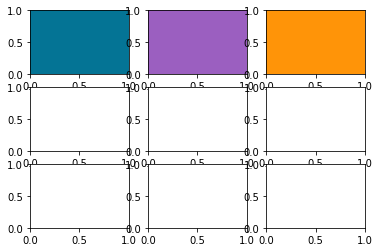

In [73]:
nrows=3
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

i=0
for row in range(nrows):
    for col in range(ncols):
        axs[row,col].set_facecolor(best_colors[i])
        i+=1

In [ ]:
for ax in axs:
    print(ax)

In [31]:
axs[0,0]

In [8]:
from random import randint
colors = []

for i in range(1000):
    colors.append('#%06X' % randint(0, 0xFFFFFF))